In [48]:
#Import packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

In [2]:
#Import dataset
files = ['merged_all_2F.csv','merged_all_3F.csv','merged_all_4F.csv']
frames = []
for f in files:
    frames.append(pd.read_csv(f))
df = pd.concat(frames)

In [3]:
#Temperature formula from paper
temp_convert = lambda x: (x - 32) * 5/9 + 273.15

In [4]:
#Data transformations
df['time'] = pd.to_datetime(df['time'])
df['Zone Temperature'] = df['Zone Temperature'].apply(temp_convert)
df['Outside Air Temp'] = df['Outside Air Temp'].apply(temp_convert)
df['cooling_thermal_power'] = 1.2041 * 1012.0 * df['Actual Supply Flow'] * (df['Zone Temperature'] - df['Outside Air Temp'])
df['day'] = df['time'].dt.dayofweek
df = df.replace({"day": {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}})
df['hour'] = df['time'].dt.hour

In [41]:
#Select zone and time range
feature_list = ['time','Actual Sup Flow SP','Zone Temperature','Actual Supply Flow','energy','Outside Air Temp','Humidity']
plot_df = df.copy()
#Filter Room ID
plot_df = plot_df[plot_df['Unnamed: 0'] == 0]
#Filter Features
plot_df = plot_df[feature_list]
#Filter Time range
daterange = (plot_df['time'] > '12/1/2018') & (plot_df['time'] <= '1/1/2019')
df_test = plot_df.loc[daterange]

daterange = (plot_df['time'] > '10/11/2017') & (plot_df['time'] <= '06/07/2018')
plot_df = plot_df.loc[daterange]
#Sort by time
plot_df = plot_df.groupby([plot_df['time'].dt.date]).mean()
plot_df = plot_df.sort_values(by='time')
plot_df.head()

,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity
time,,,,,,
2017-10-11,427.8200,295.479630,436.463333,12.551916,293.638889,59.0
2017-10-13,398.1600,295.563889,387.500000,11.346948,293.044444,57.0
2017-10-15,624.4300,296.694444,625.457500,20.496077,293.638889,59.0
2017-10-17,466.2500,295.781944,471.917500,14.451306,298.600000,47.0
2017-10-19,318.3875,295.809722,289.680000,11.692586,294.088889,58.0


In [29]:
#Check intervals between readings
plot_df['interval'] = plot_df['time'].diff().dt.days
plot_df

,time,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,interval
0,2017-07-31,434.9100,295.888889,436.710000,14.546283,293.705556,59.0,NaN
1,2017-10-11,425.0000,295.479630,424.636667,13.152633,293.083333,59.0,72.0
2,2017-10-13,392.5000,295.636111,388.062500,12.423034,292.561111,57.0,2.0
3,2017-10-15,376.1025,296.408333,378.020000,11.886605,292.905556,58.0,2.0
4,2017-10-17,419.1225,296.133333,409.067500,13.055618,297.283333,47.0,2.0
...,...,...,...,...,...,...,...,...
171,2018-12-31,135.2560,297.856667,160.762000,5.806040,287.944444,37.0,1.0
172,2019-01-01,221.2500,294.180556,211.960000,6.537644,285.511111,43.0,1.0
173,2019-01-02,333.8740,296.046667,339.166000,11.286080,286.811111,36.0,1.0
174,2019-01-04,433.1460,297.224444,451.236000,13.929350,286.655556,35.0,2.0


In [34]:
#Check gaps in readings bigger than 3 days
plot_df[plot_df['interval'] > 3]

,time,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,interval
1,2017-10-11,425.000000,295.479630,424.636667,13.152633,293.083333,59.000000,72.0
53,2018-06-07,410.810000,296.083333,392.145000,13.011271,291.033333,52.000000,152.0
73,2018-08-20,244.117692,296.781624,255.546154,8.300370,296.504274,52.307692,36.0
114,2018-10-04,413.098889,296.326543,410.895556,14.422898,294.016667,54.000000,5.0
117,2018-11-05,210.268000,298.272222,213.840000,7.074736,291.416667,56.000000,30.0


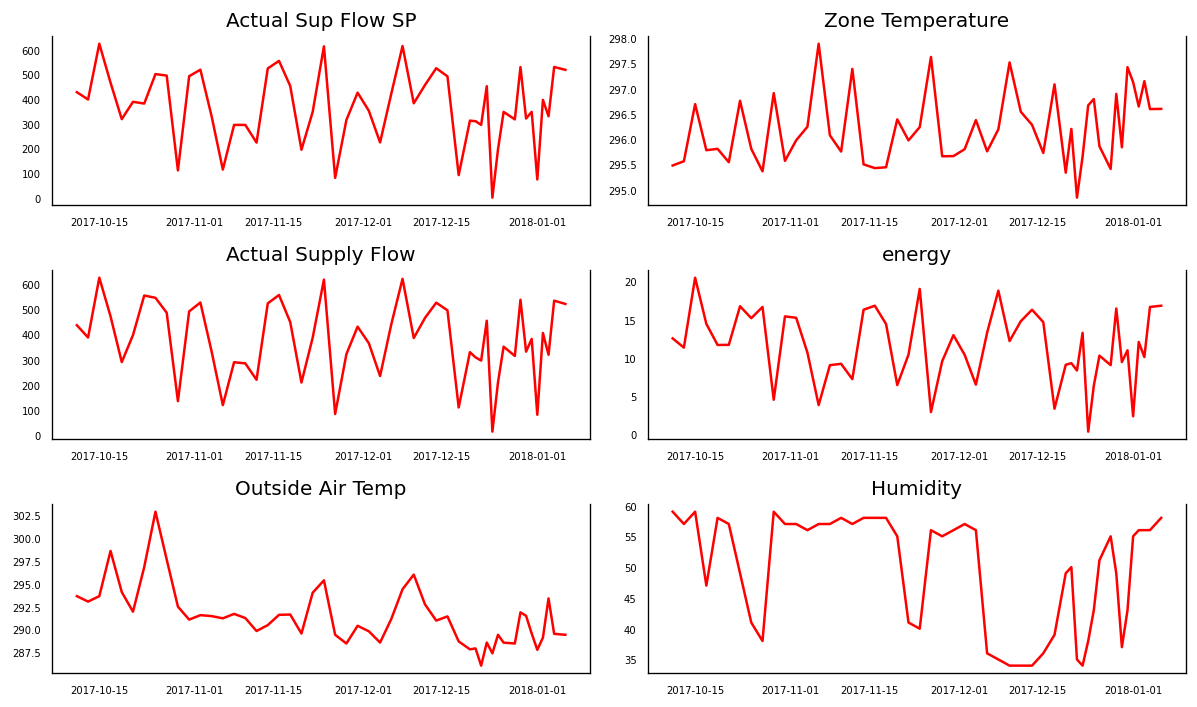

In [44]:
#Plot features during period of consistent readings
coluns = ['Actual Sup Flow SP','Zone Temperature','Actual Supply Flow','energy','Outside Air Temp','Humidity']
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = plot_df[[coluns[i]]]
    ax.plot(data, color='red')
    # Decorations
    ax.set_title(coluns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [45]:
train_df = plot_df[:40]
test_df = plot_df[40:]

In [47]:
test_df

,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity
time,,,,,,
2017-12-25,195.940000,296.795556,209.102000,6.364569,289.400000,43.000000
2017-12-26,347.777778,295.861111,351.115556,10.294737,288.539506,51.111111
2017-12-28,317.380000,295.411111,314.177500,9.053184,288.444444,55.000000
2017-12-29,529.714000,296.897778,537.656000,16.462950,291.866667,49.000000
2017-12-30,320.862500,295.840278,331.365000,9.455255,291.483333,37.000000
2017-12-31,347.862000,297.426667,381.702000,10.995313,289.538889,43.000000
2018-01-01,73.750000,297.130556,80.135000,2.355395,287.750000,55.000000
2018-01-02,396.452000,296.647778,405.414000,12.087226,289.088889,56.000000
2018-01-03,330.000000,297.150000,318.730000,10.109642,293.394444,56.000000


In [51]:
#fit model
model = AutoReg(train_df['energy'], lags=5)
model_fit = model.fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [63]:
#Predict
pred = model_fit.predict(start=len(train_df), end=(len(train_df)+12), dynamic=False)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
D:\Anaconda\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


<AxesSubplot:>

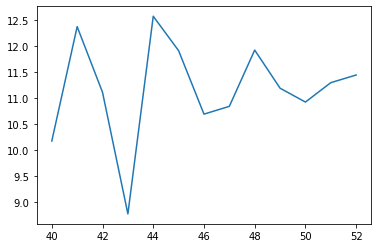

In [64]:
#plot prediction
pred.plot.line()

<AxesSubplot:xlabel='time'>

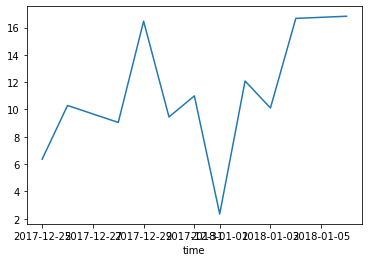

In [66]:
#Actuals
test_df['energy'].plot.line()